<a href="https://colab.research.google.com/github/Bx1Rob/DATA71200-Final-Project/blob/main/Copy_Project_1(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA 7200 PROJECT**

**Project Goal**



1.   Predict the likelihood of working in the nonprofit sector by sex and education (maybe disability and by region as well)
2.   Identify how demographic patterns align with nonprofit employment

## *Connect Part 1*

Step 1: Load your data, including testing/training split from Project 1.
* Your testing and training split should be balanced
* Your data should be clean and missing data should be addressed

Step 2: (If not already done in Project 1) Prepare your data
* Make sure that all your appropriate variables are converted to categorical variables (as ordinal or one hot)
*Perform any necessary feature scaling

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ok7H1bc_n2I3RTgeeEw1QYScpoAxKwJj
From (redirected): https://drive.google.com/uc?export=download&id=1ok7H1bc_n2I3RTgeeEw1QYScpoAxKwJj&confirm=t&uuid=9d14ccf7-71bc-4caf-8b46-f118567ce7aa
To: /content/psam_pusb.csv
100%|██████████| 2.23G/2.23G [00:25<00:00, 88.5MB/s]


Loaded shape: (3435956, 6)


,AGEP,COW,SCHL,SEX,DIS,ESR
0,29,1.0,17.0,1,2,1.0
1,33,NaN,14.0,2,2,6.0
2,18,1.0,19.0,2,2,1.0
3,49,1.0,17.0,1,2,6.0
4,64,1.0,19.0,1,2,1.0


After 18+ & employed filter: (1576914, 6)
Train size: (1182685, 4)  Test size: (394229, 4)
Train class balance:
 nonprofit_worker
0    0.892234
1    0.107766
Name: proportion, dtype: float64
Test class balance:
 nonprofit_worker
0    0.892235
1    0.107765
Name: proportion, dtype: float64
DataFrame.info():
<class 'pandas.core.frame.DataFrame'>
Index: 1182685 entries, 2550531 to 1921774
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   AGEP              1182685 non-null  int64  
 1   SEX               1182685 non-null  int64  
 2   SCHL              1182685 non-null  float64
 3   DIS               1182685 non-null  int64  
 4   nonprofit_worker  1182685 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 54.1 MB

DataFrame.describe():


,AGEP,SEX,SCHL,DIS,nonprofit_worker
count,1.182685e+06,1.182685e+06,1.182685e+06,1.182685e+06,1.182685e+06
mean,4.425062e+01,1.484018e+00,1.890472e+01,1.927300e+00,1.077658e-01
std,1.493846e+01,4.997447e-01,3.134828e+00,2.596433e-01,3.100845e-01
min,1.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.200000e+01,1.000000e+00,1.600000e+01,2.000000e+00,0.000000e+00
50%,4.400000e+01,1.000000e+00,1.900000e+01,2.000000e+00,0.000000e+00
75%,5.600000e+01,2.000000e+00,2.100000e+01,2.000000e+00,0.000000e+00
max,9.500000e+01,2.000000e+00,2.400000e+01,2.000000e+00,1.000000e+00


Saved to Drive:
 - pums_train_clean.csv
 - pums_test_clean.csv


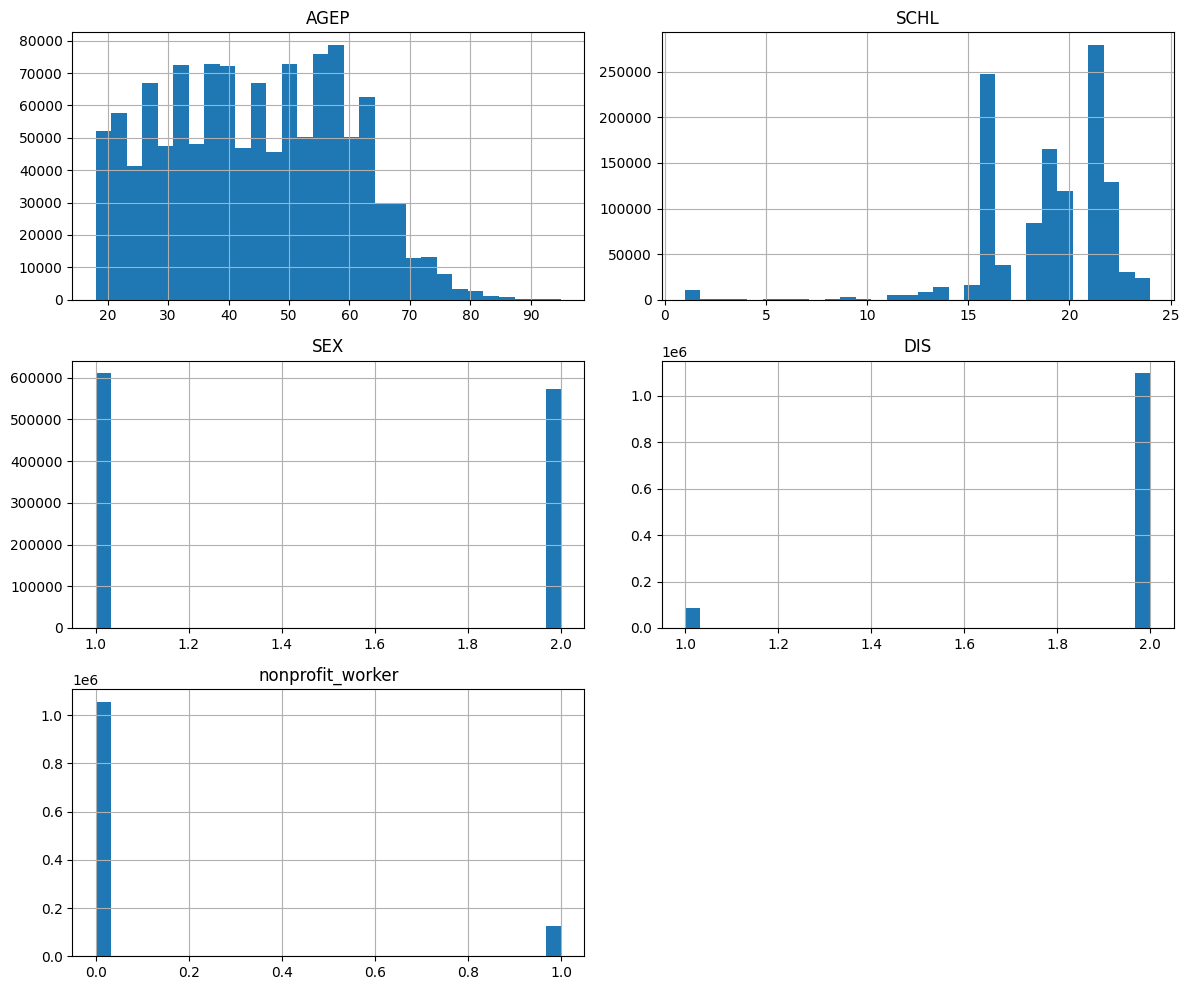

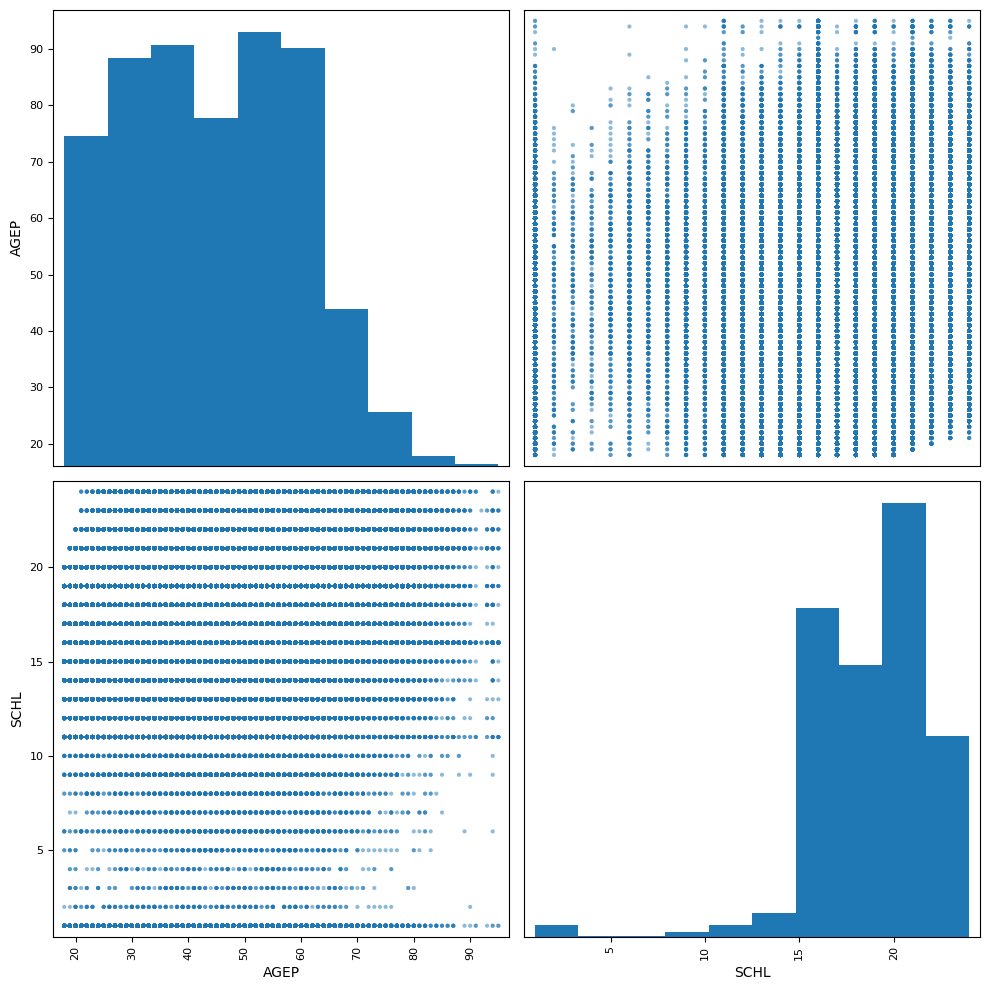

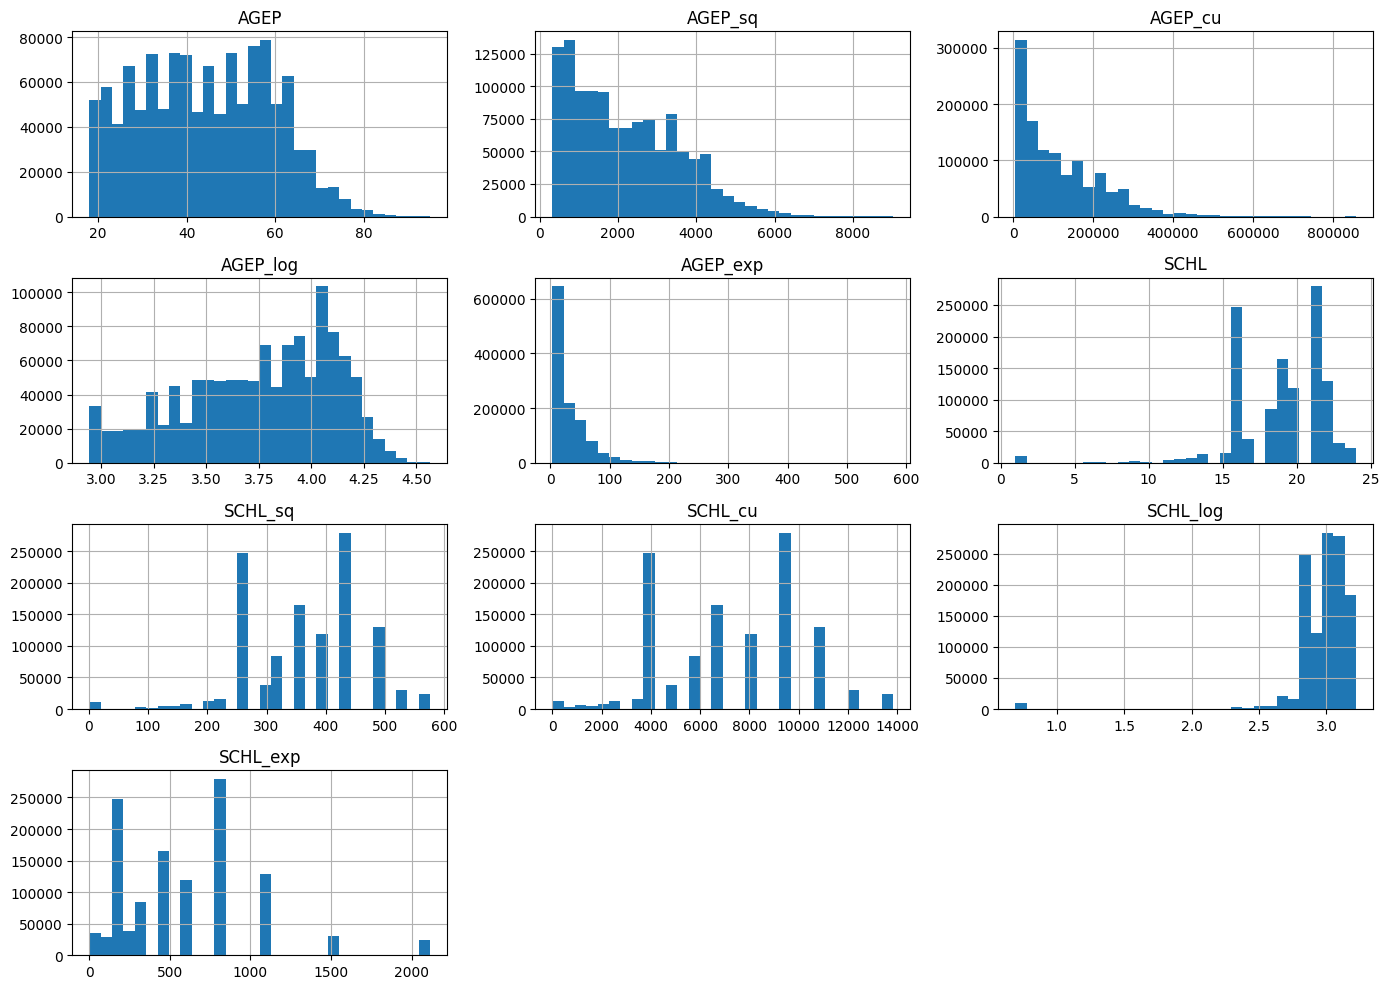

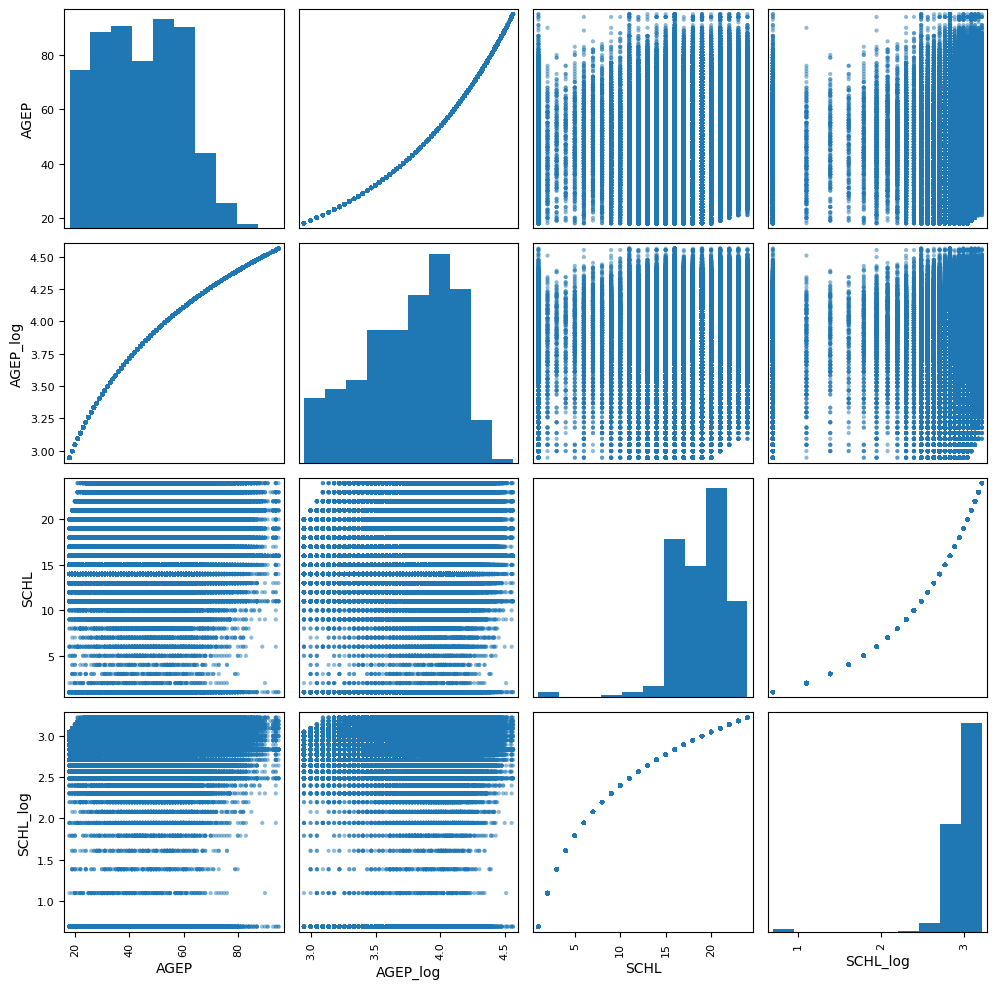

In [ ]:
# --------------------- STEP 1 : Setup & download ------------------------
!pip install gdown

import gdown
import pandas as pd
import numpy as np
from pathlib import Path

# --- Paths ---
DATA_DIR = Path(".")  # change this if you want a specific folder
DATA_DIR.mkdir(exist_ok=True)

url = "https://drive.google.com/uc?export=download&id=1ok7H1bc_n2I3RTgeeEw1QYScpoAxKwJj"
output = DATA_DIR / "psam_pusb.csv"  # local filename
gdown.download(url, str(output), quiet=False)

PUMS_FILE = output

# --- Columns to load ---
USECOLS = [
    "AGEP",
    "SEX",
    "SCHL",
    "ESR",
    "COW",
    "DIS",
    # "ST",       # will uncomment I i need to read State
    # "REGION",   # will uncomment if I use instead of ST
]

raw_df = pd.read_csv(PUMS_FILE, usecols=USECOLS)
print("Loaded shape:", raw_df.shape)
display(raw_df.head())

available_cols = pd.read_csv(PUMS_FILE, nrows=0).columns.tolist()

if "REGION" not in raw_df.columns and "ST" not in raw_df.columns and "ST" in available_cols:
    raw_df_st = pd.read_csv(PUMS_FILE, usecols=["ST"])
    if len(raw_df_st) == len(raw_df):
        raw_df["ST"] = raw_df_st["ST"]

# Construct REGION from ST
if "REGION" not in raw_df.columns and "ST" in raw_df.columns:
    northeast = {9, 23, 25, 33, 34, 36, 42, 44, 50}
    midwest   = {17, 18, 19, 20, 26, 27, 29, 31, 38, 39, 46, 55}
    south     = {1, 5, 10, 11, 12, 13, 21, 22, 24, 28, 37, 40, 45, 47, 48, 51, 54}
    west      = {2, 4, 6, 8, 15, 16, 30, 32, 35, 41, 49, 53, 56}

    def st_to_region(st):
        try:
            st = int(st)
        except Exception:
            return np.nan
        if st in northeast: return 1
        if st in midwest:   return 2
        if st in south:     return 3
        if st in west:      return 4
        return np.nan

    raw_df["REGION"] = raw_df["ST"].map(st_to_region)

# --- Keep adults (18+) & employed civilians (ESR = 1 or 2) ---
if "AGEP" in raw_df.columns and "ESR" in raw_df.columns:
    raw_df = raw_df[(raw_df["AGEP"] >= 18) & (raw_df["ESR"].isin([1, 2]))].copy()

print("After 18+ & employed filter:", raw_df.shape)

# Check for variables missing
for needed in ["AGEP", "SEX", "SCHL", "ESR", "COW", "DIS"]:
    if needed not in raw_df.columns:
        print(f"NOTE: Column '{needed}' not found; it will be dropped if referenced later.")

# --------------------- STEP 2: Train/test split ------------------------------

from sklearn.model_selection import train_test_split

# Label: nonprofit worker (COW = 2)
raw_df["nonprofit_worker"] = (
    raw_df.get("COW", pd.Series([np.nan] * len(raw_df))) == 2
).astype(int)

# Choose variables for feature columns
candidate_features = ["AGEP", "SEX", "SCHL", "DIS"]  # REGION possible later
feature_cols = [c for c in candidate_features if c in raw_df.columns]
target_col = "nonprofit_worker"

# Drop rows with missing target
df = raw_df.dropna(subset=[target_col]).copy()

# Split features & target
X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))

# ------------- STEP 3: Combine feature and target for inspection -----------

train_df = X_train.copy()
train_df[target_col] = y_train.values

print("DataFrame.info():")
train_df.info()

print("\nDataFrame.describe():")
display(train_df.describe(include="all"))

# ----------- STEP 4: Impute missing values; save cleaned train/test --------

from sklearn.impute import SimpleImputer

numeric_cols = [c for c in ["AGEP", "SCHL"] if c in X_train.columns]
categorical_cols = [c for c in ["SEX", "DIS", "REGION"] if c in X_train.columns]

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_num = (
    pd.DataFrame(num_imputer.fit_transform(X_train[numeric_cols]),
                 columns=numeric_cols, index=X_train.index)
    if numeric_cols else pd.DataFrame(index=X_train.index)
)

X_train_cat = (
    pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_cols]),
                 columns=categorical_cols, index=X_train.index)
    if categorical_cols else pd.DataFrame(index=X_train.index)
)

X_train_clean = pd.concat([X_train_num, X_train_cat], axis=1)

X_test_num = (
    pd.DataFrame(num_imputer.transform(X_test[numeric_cols]),
                 columns=numeric_cols, index=X_test.index)
    if numeric_cols else pd.DataFrame(index=X_test.index)
)

X_test_cat = (
    pd.DataFrame(cat_imputer.transform(X_test[categorical_cols]),
                 columns=categorical_cols, index=X_test.index)
    if categorical_cols else pd.DataFrame(index=X_test.index)
)

X_test_clean = pd.concat([X_test_num, X_test_cat], axis=1)

train_clean_df = X_train_clean.copy()
train_clean_df[target_col] = y_train.values

test_clean_df = X_test_clean.copy()
test_clean_df[target_col] = y_test.values

# Save cleaned data
train_out = DATA_DIR / "pums_train_clean.csv"
test_out = DATA_DIR / "pums_test_clean.csv"

train_clean_df.to_csv(train_out, index=False)
test_clean_df.to_csv(test_out, index=False)

print("Saved to Drive:")
print(" -", train_out)
print(" -", test_out)

# ---------------------- STEP 5: VISUALIZE  ------------ -----------------------

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

df["SEX_label"] = df["SEX"].map({1: "Male", 2: "Female"})
df["DIS_label"] = df["DIS"].map({1: "With Disability", 2: "No Disability"})

_ = train_clean_df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

sm_cols = [c for c in ["AGEP", "SCHL"] if c in train_clean_df.columns]
if len(sm_cols) >= 2:
    _ = scatter_matrix(train_clean_df[sm_cols], figsize=(10, 10), diagonal="hist")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for scatter_matrix; skipping.")

# ----------------- STEP 6: TRASNFORM AGEP & SCHL ---------------------------

def safe_log(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

def safe_exp(x):
    # avoid overflow in demo
    return np.exp(np.clip(x, a_min=None, a_max=12))

transformed = train_clean_df.copy()

numeric_for_tx = []
for col in ["AGEP", "SCHL"]:
    if col in transformed.columns:
        transformed[f"{col}_sq"]  = transformed[col] ** 2
        transformed[f"{col}_cu"]  = transformed[col] ** 3
        transformed[f"{col}_log"] = safe_log(transformed[col])
        std = transformed[col].std() if transformed[col].std() else 1.0
        transformed[f"{col}_exp"] = safe_exp(transformed[col] / std)
        numeric_for_tx.extend([col, f"{col}_sq", f"{col}_cu", f"{col}_log", f"{col}_exp"])

if numeric_for_tx:
    _ = transformed[numeric_for_tx].hist(figsize=(14, 10), bins=30)
    plt.tight_layout()
    plt.show()

    sm_show = [c for c in ["AGEP", "AGEP_log", "SCHL", "SCHL_log"] if c in transformed.columns]
    if len(sm_show) >= 2:
        _ = scatter_matrix(transformed[sm_show], figsize=(10, 10), diagonal="hist")
        plt.tight_layout()
        plt.show()
else:
    print("AGEP/SCHL not available; skipping transformations.")


# **Part 2**

Step 3: Examine your target attribute. Based on the data exploration you did in Project 1, confirm and examine the attribute you are going to predict.

* Examine and plot the distribution of the target attribute in your training set (e.g., is it Gaussian, uniform, logarithmic). This will help you interpret the performance of different algorithms on your data.

Target distribution (train):
nonprofit_worker
0    1055232
1     127453
Name: count, dtype: int64

Target distribution (train, proportion):
nonprofit_worker
0    0.892234
1    0.107766
Name: proportion, dtype: float64


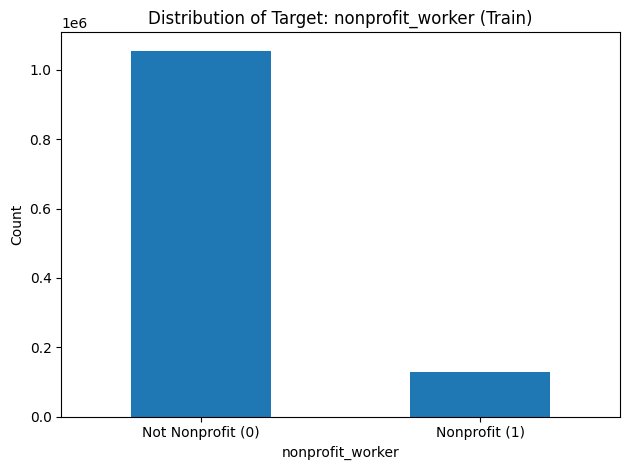

In [ ]:
import matplotlib.pyplot as plt

# Text summary
print("Target distribution (train):")
print(y_train.value_counts())
print("\nTarget distribution (train, proportion):")
print(y_train.value_counts(normalize=True))

# Plot
ax = y_train.value_counts().sort_index().plot(
    kind="bar",
    rot=0
)
ax.set_xticklabels(["Not Nonprofit (0)", "Nonprofit (1)"])
ax.set_ylabel("Count")
ax.set_title("Distribution of Target: nonprofit_worker (Train)")
plt.tight_layout()
plt.show()


The model wlil be heavily misbalanced.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify features from your current X_train
numeric_features = [c for c in ["AGEP", "SCHL"] if c in X_train.columns]
categorical_features = [c for c in ["SEX", "DIS", "REGION"] if c in X_train.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# NOTE: In your writeup, mention that the target is imbalanced (as shown in your plot)
# and that you are using scaling + one-hot encoding for appropriate features.


Numeric features: ['AGEP', 'SCHL']
Categorical features: ['SEX', 'DIS']


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logreg_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]
)

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(random_state=42))
    ]
)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def evaluate_model(name, model, X_train, y_train, X_test, y_test, average="binary"):
    """
    Fits the model and prints precision, recall, F1 on train and test.
    Treats '1' as the positive class.
    """
    print("=" * 70)
    print(f"Model: {name}")
    print("=" * 70)

    # Fit
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Metrics
    p_train, r_train, f_train, _ = precision_recall_fscore_support(
        y_train, y_pred_train, average=average, zero_division=0
    )
    p_test, r_test, f_test, _ = precision_recall_fscore_support(
        y_test, y_pred_test, average=average, zero_division=0
    )

    print("TRAIN metrics:")
    print(f"  Precision: {p_train:.4f}")
    print(f"  Recall:    {r_train:.4f}")
    print(f"  F1-score:  {f_train:.4f}")

    print("\nTEST metrics:")
    print(f"  Precision: {p_test:.4f}")
    print(f"  Recall:    {r_test:.4f}")
    print(f"  F1-score:  {f_test:.4f}")

    print("\nClassification report (TEST):")
    print(classification_report(y_test, y_pred_test, digits=4, zero_division=0))


In [ ]:
evaluate_model(
    "Logistic Regression (default)",
    logreg_clf,
    X_train, y_train,
    X_test, y_test
)

evaluate_model(
    "Random Forest (default)",
    rf_clf,
    X_train, y_train,
    X_test, y_test
)


Model: Logistic Regression (default)
TRAIN metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

TEST metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8922    1.0000    0.9430    351745
           1     0.0000    0.0000    0.0000     42484

    accuracy                         0.8922    394229
   macro avg     0.4461    0.5000    0.4715    394229
weighted avg     0.7961    0.8922    0.8414    394229

Model: Random Forest (default)
TRAIN metrics:
  Precision: 0.7365
  Recall:    0.0018
  F1-score:  0.0036

TEST metrics:
  Precision: 0.2784
  Recall:    0.0006
  F1-score:  0.0013

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8923    0.9998    0.9430    351745
           1     0.2784    0.0006    0.0013     42484

    accuracy                         0.8921    394229
   macro avg     0.5853  

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer    = make_scorer(recall_score, zero_division=0)
f1_scorer        = make_scorer(f1_score, zero_division=0)

def cross_val_metrics(name, model, X, y):
    print("=" * 70)
    print(f"Cross-validation metrics: {name}")
    print("=" * 70)

    p_scores = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer)
    r_scores = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer)
    f_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)

    print(f"Precision: mean={p_scores.mean():.4f}, std={p_scores.std():.4f}")
    print(f"Recall:    mean={r_scores.mean():.4f}, std={r_scores.std():.4f}")
    print(f"F1-score:  mean={f_scores.mean():.4f}, std={f_scores.std():.4f}")

# Logistic Regression CV (default)
cross_val_metrics("Logistic Regression (default)", logreg_clf, X_train, y_train)

# Random Forest CV (default)
cross_val_metrics("Random Forest (default)", rf_clf, X_train, y_train)


Cross-validation metrics: Logistic Regression (default)
Precision: mean=0.0000, std=0.0000
Recall:    mean=0.0000, std=0.0000
F1-score:  mean=0.0000, std=0.0000
Cross-validation metrics: Random Forest (default)
Precision: mean=0.2520, std=0.0339
Recall:    mean=0.0009, std=0.0001
F1-score:  mean=0.0017, std=0.0002


In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
from copy import deepcopy

logreg_param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
}

logreg_grid = GridSearchCV(
    estimator=logreg_clf,
    param_grid=logreg_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

logreg_grid.fit(X_train, y_train)

print("Best parameters (Logistic Regression):", logreg_grid.best_params_)
print("Best CV F1 (Logistic Regression):", logreg_grid.best_score_)

logreg_results = pd.DataFrame(logreg_grid.cv_results_)
logreg_results_sorted = logreg_results.sort_values("mean_test_score", ascending=False)

best_params_logreg  = logreg_results_sorted.iloc[0]["params"]
worst_params_logreg = logreg_results_sorted.iloc[-1]["params"]

print("\nBest param setting (LogReg):", best_params_logreg)
print("Worst param setting (LogReg):", worst_params_logreg)

logreg_best = deepcopy(logreg_clf)
logreg_best.set_params(**best_params_logreg)

logreg_worst = deepcopy(logreg_clf)
logreg_worst.set_params(**worst_params_logreg)

evaluate_model("Logistic Regression (BEST params)", logreg_best, X_train, y_train, X_test, y_test)
evaluate_model("Logistic Regression (WORST params)", logreg_worst, X_train, y_train, X_test, y_test)


Best parameters (Logistic Regression): {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV F1 (Logistic Regression): 0.0

Best param setting (LogReg): {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Worst param setting (LogReg): {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Model: Logistic Regression (BEST params)
TRAIN metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

TEST metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8922    1.0000    0.9430    351745
           1     0.0000    0.0000    0.0000     42484

    accuracy                         0.8922    394229
   macro avg     0.4461    0.5000    0.4715    394229
weighted avg     0.7961    0.8922    0.8414    394229

Model: Logistic Regression (WORST params)
TRAIN metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score

In [ ]:
from sklearn.model_selection import GridSearchCV
# Code had to be mofidifed.
rf_param_grid = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5],
}

rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

rf_grid.fit(X_train, y_train)

print("Best parameters (Random Forest):", rf_grid.best_params_)
print("Best CV F1 (Random Forest):", rf_grid.best_score_)

rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results_sorted = rf_results.sort_values("mean_test_score", ascending=False)

best_params_rf  = rf_results_sorted.iloc[0]["params"]
worst_params_rf = rf_results_sorted.iloc[-1]["params"]

print("\nBest param setting (RF):", best_params_rf)
print("Worst param setting (RF):", worst_params_rf)

rf_best = deepcopy(rf_clf)
rf_best.set_params(**best_params_rf)

rf_worst = deepcopy(rf_clf)
rf_worst.set_params(**worst_params_rf)

evaluate_model("Random Forest (BEST params)", rf_best, X_train, y_train, X_test, y_test)
evaluate_model("Random Forest (WORST params)", rf_worst, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

Due to computational limits, the Random Forest grid search was performed with a reduced hyperparameter grid (varying number of trees and maximum depth) and 3-fold cross-validation instead of 5-fold. This still allowed us to compare best and worst-performing configurations while staying within resource limits.

In [ ]:
from sklearn.model_selection import GridSearchCV
from copy import deepcopy
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Use a lighter CV: 3 folds instead of 5
cv_small = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Much smaller RF grid (still varies 2 hyperparameters)
rf_param_grid = {
    "model__n_estimators": [50, 100],   # fewer trees
    "model__max_depth": [5, None],      # shallow vs unlimited depth
}

# IMPORTANT: n_jobs=1 here to avoid joblib worker crashes on limited RAM machines
rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    scoring="f1",
    cv=cv_small,
    n_jobs=1,
    return_train_score=True
)

print("Starting lighter Random Forest grid search...")
rf_grid.fit(X_train, y_train)
print("Grid search done.")

print("Best parameters (Random Forest):", rf_grid.best_params_)
print("Best CV F1 (Random Forest):", rf_grid.best_score_)

rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results_sorted = rf_results.sort_values("mean_test_score", ascending=False)

best_params_rf  = rf_results_sorted.iloc[0]["params"]
worst_params_rf = rf_results_sorted.iloc[-1]["params"]

print("\nBest param setting (RF):", best_params_rf)
print("Worst param setting (RF):", worst_params_rf)

rf_best = deepcopy(rf_clf)
rf_best.set_params(**best_params_rf)

rf_worst = deepcopy(rf_clf)
rf_worst.set_params(**worst_params_rf)

evaluate_model("Random Forest (BEST params, light grid)", rf_best,
               X_train, y_train, X_test, y_test)

evaluate_model("Random Forest (WORST params, light grid)", rf_worst,
               X_train, y_train, X_test, y_test)


Starting lighter Random Forest grid search...
Grid search done.
Best parameters (Random Forest): {'model__max_depth': None, 'model__n_estimators': 50}
Best CV F1 (Random Forest): 0.0021088853924943335

Best param setting (RF): {'model__max_depth': None, 'model__n_estimators': 50}
Worst param setting (RF): {'model__max_depth': 5, 'model__n_estimators': 50}
Model: Random Forest (BEST params, light grid)
TRAIN metrics:
  Precision: 0.7176
  Recall:    0.0019
  F1-score:  0.0038

TEST metrics:
  Precision: 0.2830
  Recall:    0.0007
  F1-score:  0.0014

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8923    0.9998    0.9430    351745
           1     0.2830    0.0007    0.0014     42484

    accuracy                         0.8921    394229
   macro avg     0.5877    0.5002    0.4722    394229
weighted avg     0.8266    0.8921    0.8415    394229

Model: Random Forest (WORST params, light grid)
TRAIN metrics:
  Precision: 0.0000
  Re

Soince it was imbalance I will try to class weight.

In [ ]:
# Balanced Regression

logreg_balanced_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            n_jobs=-1,
            class_weight="balanced"
        ))
    ]
)

evaluate_model(
    "Logistic Regression (class_weight='balanced')",
    logreg_balanced_clf,
    X_train, y_train,
    X_test, y_test
)

cross_val_metrics(
    "Logistic Regression (class_weight='balanced')",
    logreg_balanced_clf,
    X_train, y_train
)


Model: Logistic Regression (class_weight='balanced')
TRAIN metrics:
  Precision: 0.1691
  Recall:    0.6351
  F1-score:  0.2671

TEST metrics:
  Precision: 0.1689
  Recall:    0.6354
  F1-score:  0.2668

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9339    0.6223    0.7469    351745
           1     0.1689    0.6354    0.2668     42484

    accuracy                         0.6237    394229
   macro avg     0.5514    0.6288    0.5068    394229
weighted avg     0.8515    0.6237    0.6952    394229

Cross-validation metrics: Logistic Regression (class_weight='balanced')
Precision: mean=0.1691, std=0.0009
Recall:    mean=0.6352, std=0.0034
F1-score:  mean=0.2671, std=0.0014


In [ ]:
#Balanced Random Forest

rf_balanced_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            random_state=42,
            class_weight="balanced"
        ))
    ]
)

evaluate_model(
    "Random Forest (class_weight='balanced')",
    rf_balanced_clf,
    X_train, y_train,
    X_test, y_test
)

cross_val_metrics(
    "Random Forest (class_weight='balanced')",
    rf_balanced_clf,
    X_train, y_train
)


Model: Random Forest (class_weight='balanced')
TRAIN metrics:
  Precision: 0.1751
  Recall:    0.6796
  F1-score:  0.2784

TEST metrics:
  Precision: 0.1714
  Recall:    0.6658
  F1-score:  0.2726

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9380    0.6112    0.7401    351745
           1     0.1714    0.6658    0.2726     42484

    accuracy                         0.6170    394229
   macro avg     0.5547    0.6385    0.5063    394229
weighted avg     0.8554    0.6170    0.6897    394229

Cross-validation metrics: Random Forest (class_weight='balanced')
Precision: mean=0.1720, std=0.0006
Recall:    mean=0.6629, std=0.0018
F1-score:  mean=0.2731, std=0.0008




ROC & Precision


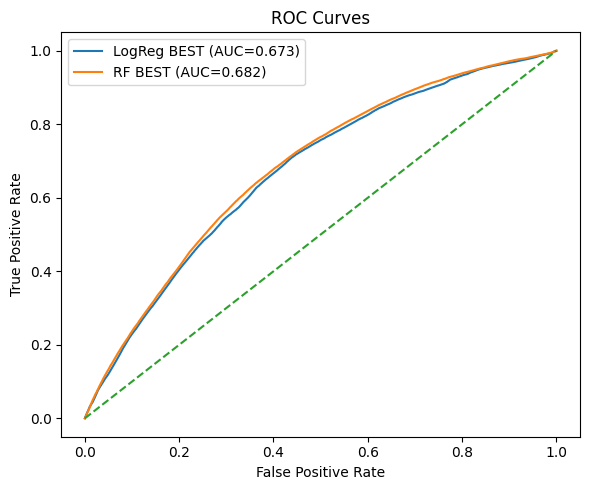

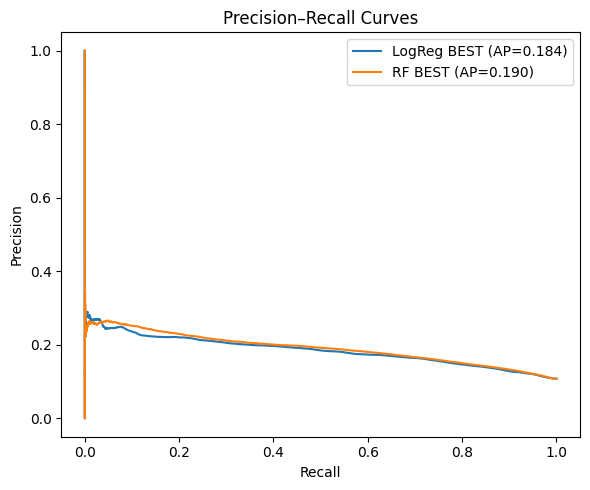

In [ ]:
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

def plot_roc_pr_curves(models, X_test, y_test):
    # ROC
    plt.figure(figsize=(6, 5))
    for name, model in models:
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Precision–Recall
    plt.figure(figsize=(6, 5))
    for name, model in models:
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: compare best-tuned models
logreg_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)

models_to_compare = [
    ("LogReg BEST", logreg_best),
    ("RF BEST", rf_best),
]

plot_roc_pr_curves(models_to_compare, X_test, y_test)


Logistic Regression coefficients

In [ ]:
import numpy as np

# Ensure model is fitted
logreg_best.fit(X_train, y_train)

preprocess_fitted = logreg_best.named_steps["preprocess"]
feature_names = preprocess_fitted.get_feature_names_out()

logreg_model = logreg_best.named_steps["model"]
coef = logreg_model.coef_.ravel()

logreg_coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef
})
logreg_coef_df["abs_coef"] = logreg_coef_df["coef"].abs()
logreg_coef_df_sorted = logreg_coef_df.sort_values("abs_coef", ascending=False)

logreg_coef_df_sorted.head(20)


,feature,coef,abs_coef
2,cat__SEX_1,-0.936672,0.936672
5,cat__DIS_2,-0.632510,0.632510
1,num__SCHL,0.522698,0.522698
4,cat__DIS_1,-0.451244,0.451244
3,cat__SEX_2,-0.147082,0.147082
0,num__AGEP,0.074254,0.074254


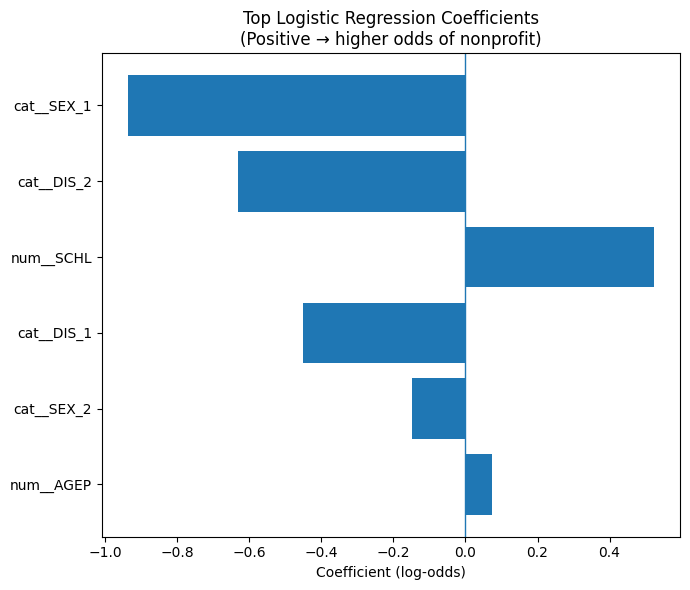

In [ ]:
top_n = 15
top_features = logreg_coef_df_sorted.head(top_n)

plt.figure(figsize=(7, 6))
plt.barh(top_features["feature"], top_features["coef"])
plt.axvline(0, linewidth=1)
plt.gca().invert_yaxis()
plt.title("Top Logistic Regression Coefficients\n(Positive → higher odds of nonprofit)")
plt.xlabel("Coefficient (log-odds)")
plt.tight_layout()
plt.show()


In [ ]:
rf_best.fit(X_train, y_train)

preprocess_fitted = rf_best.named_steps["preprocess"]
feature_names = preprocess_fitted.get_feature_names_out()

rf_model = rf_best.named_steps["model"]
rf_importances = rf_model.feature_importances_

rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

rf_importance_df.head(20)


,feature,importance
1,num__SCHL,0.522181
0,num__AGEP,0.171034
3,cat__SEX_2,0.160220
2,cat__SEX_1,0.141448
5,cat__DIS_2,0.002592
4,cat__DIS_1,0.002525


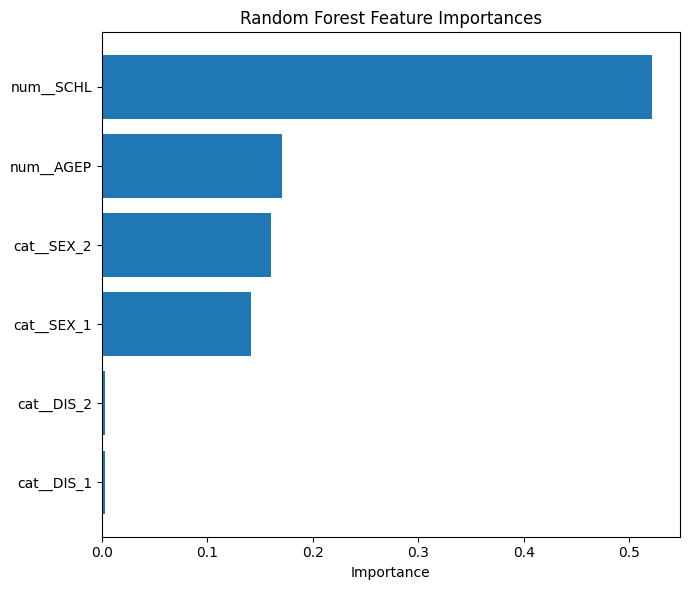

In [ ]:
top_n = 15
top_features_rf = rf_importance_df.head(top_n)

plt.figure(figsize=(7, 6))
plt.barh(top_features_rf["feature"], top_features_rf["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


STEP 3

Target distribution (train):
nonprofit_worker
0    1055232
1     127453
Name: count, dtype: int64

Target distribution (train, proportion):
nonprofit_worker
0    0.892234
1    0.107766
Name: proportion, dtype: float64


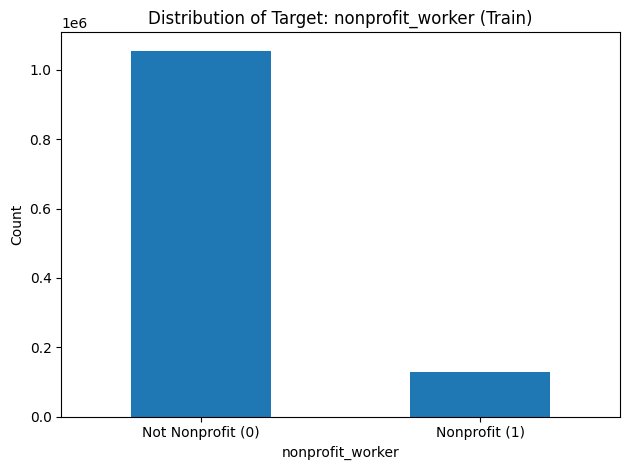

In [ ]:
import matplotlib.pyplot as plt

# Text summary
print("Target distribution (train):")
print(y_train.value_counts())
print("\nTarget distribution (train, proportion):")
print(y_train.value_counts(normalize=True))

# Plot
ax = y_train.value_counts().sort_index().plot(
    kind="bar",
    rot=0
)
ax.set_xticklabels(["Not Nonprofit (0)", "Nonprofit (1)"])
ax.set_ylabel("Count")
ax.set_title("Distribution of Target: nonprofit_worker (Train)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Logistic Regression pipeline
logreg_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]
)

# Random Forest pipeline
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(random_state=42))
    ]
)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def evaluate_model(name, model, X_train, y_train, X_test, y_test, average="binary"):
    """
    Fits the model (in case it's not already fit) and prints precision, recall, F1 on train and test.
    Assumes binary target with labels {0,1}, and we treat 1 as the positive class.
    """
    print("=" * 70)
    print(f"Model: {name}")
    print("=" * 70)

    # Fit
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Metrics
    p_train, r_train, f_train, _ = precision_recall_fscore_support(
        y_train, y_pred_train, average=average, zero_division=0
    )
    p_test, r_test, f_test, _ = precision_recall_fscore_support(
        y_test, y_pred_test, average=average, zero_division=0
    )

    print("TRAIN metrics:")
    print(f"  Precision: {p_train:.4f}")
    print(f"  Recall:    {r_train:.4f}")
    print(f"  F1-score:  {f_train:.4f}")

    print("\nTEST metrics:")
    print(f"  Precision: {p_test:.4f}")
    print(f"  Recall:    {r_test:.4f}")
    print(f"  F1-score:  {f_test:.4f}")

    print("\nClassification report (TEST):")
    print(classification_report(y_test, y_pred_test, digits=4, zero_division=0))


In [ ]:
evaluate_model(
    "Logistic Regression (default)",
    logreg_clf,
    X_train, y_train,
    X_test, y_test
)


Model: Logistic Regression (default)
TRAIN metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

TEST metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8922    1.0000    0.9430    351745
           1     0.0000    0.0000    0.0000     42484

    accuracy                         0.8922    394229
   macro avg     0.4461    0.5000    0.4715    394229
weighted avg     0.7961    0.8922    0.8414    394229



In [ ]:
evaluate_model(
    "Random Forest (default)",
    rf_clf,
    X_train, y_train,
    X_test, y_test
)


Model: Random Forest (default)
TRAIN metrics:
  Precision: 0.7365
  Recall:    0.0018
  F1-score:  0.0036

TEST metrics:
  Precision: 0.2784
  Recall:    0.0006
  F1-score:  0.0013

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8923    0.9998    0.9430    351745
           1     0.2784    0.0006    0.0013     42484

    accuracy                         0.8921    394229
   macro avg     0.5853    0.5002    0.4721    394229
weighted avg     0.8261    0.8921    0.8415    394229



In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer    = make_scorer(recall_score, zero_division=0)
f1_scorer        = make_scorer(f1_score, zero_division=0)

def cross_val_metrics(name, model, X, y):
    print("=" * 70)
    print(f"Cross-validation metrics: {name}")
    print("=" * 70)

    p_scores = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer)
    r_scores = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer)
    f_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)

    print(f"Precision: mean={p_scores.mean():.4f}, std={p_scores.std():.4f}")
    print(f"Recall:    mean={r_scores.mean():.4f}, std={r_scores.std():.4f}")
    print(f"F1-score:  mean={f_scores.mean():.4f}, std={f_scores.std():.4f}")

# Logistic Regression CV
cross_val_metrics("Logistic Regression (default)", logreg_clf, X_train, y_train)

# Random Forest CV
cross_val_metrics("Random Forest (default)", rf_clf, X_train, y_train)


Cross-validation metrics: Logistic Regression (default)
Precision: mean=0.0000, std=0.0000
Recall:    mean=0.0000, std=0.0000
F1-score:  mean=0.0000, std=0.0000
Cross-validation metrics: Random Forest (default)
Precision: mean=0.2520, std=0.0339
Recall:    mean=0.0009, std=0.0001
F1-score:  mean=0.0017, std=0.0002


In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

logreg_param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],  # works with l2, multi-class-safe
}

logreg_grid = GridSearchCV(
    estimator=logreg_clf,
    param_grid=logreg_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

logreg_grid.fit(X_train, y_train)

print("Best parameters (Logistic Regression):", logreg_grid.best_params_)
print("Best CV F1 (Logistic Regression):", logreg_grid.best_score_)


Best parameters (Logistic Regression): {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV F1 (Logistic Regression): 0.0


In [ ]:
logreg_results = pd.DataFrame(logreg_grid.cv_results_)

# Sort by mean_test_score (F1)
logreg_results_sorted = logreg_results.sort_values("mean_test_score", ascending=False)

best_params_logreg  = logreg_results_sorted.iloc[0]["params"]
worst_params_logreg = logreg_results_sorted.iloc[-1]["params"]

print("\nBest param setting (LogReg):", best_params_logreg)
print("Worst param setting (LogReg):", worst_params_logreg)

# Build models with best/worst params
from copy import deepcopy

logreg_best = deepcopy(logreg_clf)
logreg_best.set_params(**best_params_logreg)

logreg_worst = deepcopy(logreg_clf)
logreg_worst.set_params(**worst_params_logreg)

# Evaluate
evaluate_model("Logistic Regression (BEST params)", logreg_best, X_train, y_train, X_test, y_test)
evaluate_model("Logistic Regression (WORST params)", logreg_worst, X_train, y_train, X_test, y_test)



Best param setting (LogReg): {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Worst param setting (LogReg): {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Model: Logistic Regression (BEST params)
TRAIN metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

TEST metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8922    1.0000    0.9430    351745
           1     0.0000    0.0000    0.0000     42484

    accuracy                         0.8922    394229
   macro avg     0.4461    0.5000    0.4715    394229
weighted avg     0.7961    0.8922    0.8414    394229

Model: Logistic Regression (WORST params)
TRAIN metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

TEST metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Classification report (TEST):
              precision    rec

Random Forest Grid

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd

# --- Faster CV (3 folds instead of 5) ---
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Smaller, faster RF grid (still tunes 2 hyperparameters) ---
rf_param_grid = {
    "model__n_estimators": [50, 100],   # reduced tree count
    "model__max_depth": [5, None],      # shallow vs unrestricted depth
}

# --- Lighter GridSearchCV ---
# IMPORTANT: n_jobs=1 prevents "worker stopped" crashes in Colab / limited RAM machines
rf_grid = GridSearchCV(
    estimator=rf_clf,            # your pipeline with preprocessor + RF
    param_grid=rf_param_grid,
    scoring="f1",
    cv=cv_fast,
    n_jobs=1,                    # prevents memory errors; slower but safe
    return_train_score=True
)

print("Starting Random Forest grid search (fast mode)...")
rf_grid.fit(X_train, y_train)
print("Grid search completed.")

# --- Print results (same as your original expected output) ---
print("Best parameters (Random Forest):", rf_grid.best_params_)
print("Best CV F1 (Random Forest):", rf_grid.best_score_)


Starting Random Forest grid search (fast mode)...
Grid search completed.
Best parameters (Random Forest): {'model__max_depth': None, 'model__n_estimators': 50}
Best CV F1 (Random Forest): 0.0021088853924943335


In [ ]:
rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results_sorted = rf_results.sort_values("mean_test_score", ascending=False)

best_params_rf  = rf_results_sorted.iloc[0]["params"]
worst_params_rf = rf_results_sorted.iloc[-1]["params"]

print("\nBest param setting (RF):", best_params_rf)
print("Worst param setting (RF):", worst_params_rf)

from copy import deepcopy

rf_best = deepcopy(rf_clf)
rf_best.set_params(**best_params_rf)

rf_worst = deepcopy(rf_clf)
rf_worst.set_params(**worst_params_rf)

evaluate_model("Random Forest (BEST params)", rf_best, X_train, y_train, X_test, y_test)
evaluate_model("Random Forest (WORST params)", rf_worst, X_train, y_train, X_test, y_test)



Best param setting (RF): {'model__max_depth': None, 'model__n_estimators': 50}
Worst param setting (RF): {'model__max_depth': 5, 'model__n_estimators': 50}
Model: Random Forest (BEST params)
TRAIN metrics:
  Precision: 0.7176
  Recall:    0.0019
  F1-score:  0.0038

TEST metrics:
  Precision: 0.2830
  Recall:    0.0007
  F1-score:  0.0014

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8923    0.9998    0.9430    351745
           1     0.2830    0.0007    0.0014     42484

    accuracy                         0.8921    394229
   macro avg     0.5877    0.5002    0.4722    394229
weighted avg     0.8266    0.8921    0.8415    394229

Model: Random Forest (WORST params)
TRAIN metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

TEST metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8922    1

2. ROC & Precision–Recall Curves (Copy/Paste Ready Code)

Use your best logistic regression and best random forest models:

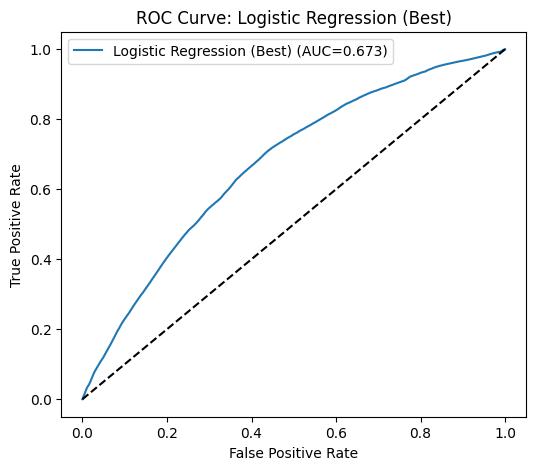

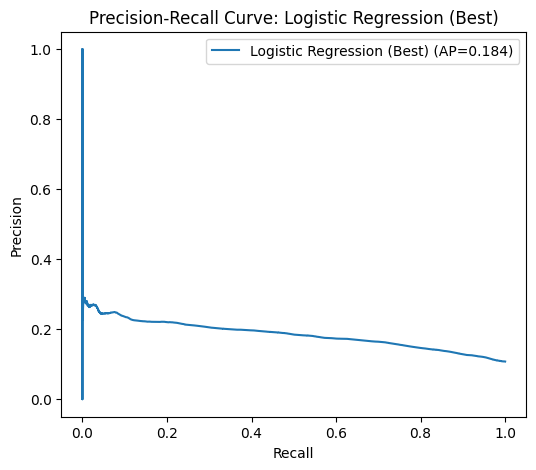

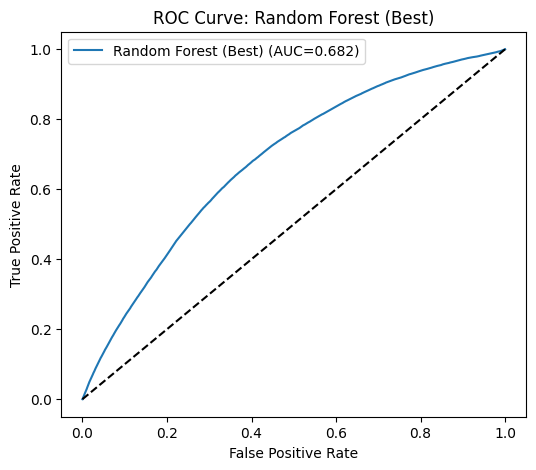

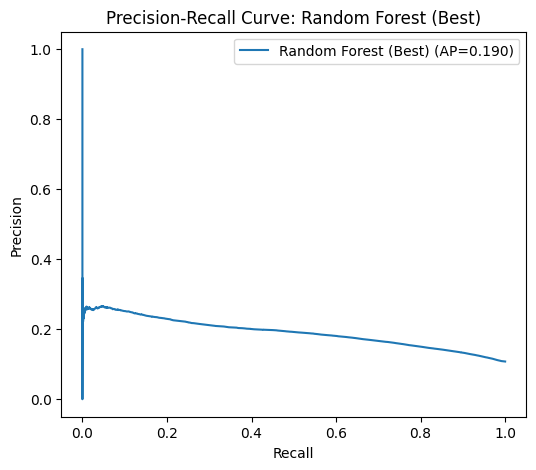

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_curves(model, X_test, y_test, name="Model"):
    y_proba = model.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {name}")
    plt.legend()
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"{name} (AP={avg_prec:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {name}")
    plt.legend()
    plt.show()

# Example with your best models
logreg_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)

plot_curves(logreg_best, X_test, y_test, name="Logistic Regression (Best)")
plot_curves(rf_best, X_test, y_test, name="Random Forest (Best)")


3. Add class_weight="balanced" to Logistic Regression AND Random Forest
Logistic Regression Balanced

In [ ]:
logreg_balanced = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]
)

evaluate_model("Logistic Regression (Balanced)", logreg_balanced,
               X_train, y_train, X_test, y_test)


Model: Logistic Regression (Balanced)
TRAIN metrics:
  Precision: 0.1691
  Recall:    0.6351
  F1-score:  0.2671

TEST metrics:
  Precision: 0.1689
  Recall:    0.6354
  F1-score:  0.2668

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9339    0.6223    0.7469    351745
           1     0.1689    0.6354    0.2668     42484

    accuracy                         0.6237    394229
   macro avg     0.5514    0.6288    0.5068    394229
weighted avg     0.8515    0.6237    0.6952    394229



Random Forest Balanced

In [ ]:
rf_balanced = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            random_state=42,
            class_weight='balanced'
        ))
    ]
)

evaluate_model("Random Forest (Balanced)", rf_balanced,
               X_train, y_train, X_test, y_test)


Model: Random Forest (Balanced)
TRAIN metrics:
  Precision: 0.1751
  Recall:    0.6796
  F1-score:  0.2784

TEST metrics:
  Precision: 0.1714
  Recall:    0.6658
  F1-score:  0.2726

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9380    0.6112    0.7401    351745
           1     0.1714    0.6658    0.2726     42484

    accuracy                         0.6170    394229
   macro avg     0.5547    0.6385    0.5063    394229
weighted avg     0.8554    0.6170    0.6897    394229



# PART 3

Train/Test - only use Training Data (as per assignment)

In [ ]:
# use if collab breaks: import pandas as pd
# use if collab breaks: import numpy as np

train_df = pd.read_csv("pums_train_clean.csv")
test_df  = pd.read_csv("pums_test_clean.csv")  # loaded but will not use as per asingment

target_col = "nonprofit_worker"

X_train = train_df.drop(columns=[target_col]).copy()
y_train = train_df[target_col].copy()

print("Training shape:", X_train.shape)
print("Class balance:\n", y_train.value_counts(normalize=True))


Training shape: (1182685, 4)
Class balance:
 nonprofit_worker
0    0.892234
1    0.107766
Name: proportion, dtype: float64


Categorical variables and scale numerics

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_cols = [c for c in ["AGEP","SCHL"] if c in X_train.columns]
cat_cols     = [c for c in ["SEX","DIS","REGION"] if c in X_train.columns]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])


PCA

Components needed for 95% variance: 4


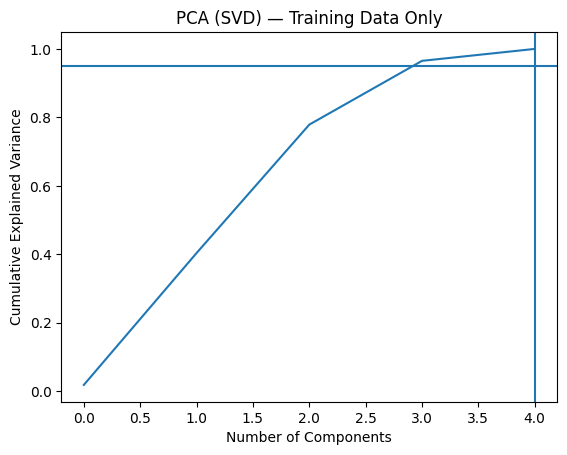

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

X_train_proc = preprocess.fit_transform(X_train)

max_components = min(200, X_train_proc.shape[1] - 1)
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X_train_proc)

cum_var = np.cumsum(svd_full.explained_variance_ratio_)
k95 = int(np.argmax(cum_var >= 0.95) + 1)

print("Components needed for 95% variance:", k95)

plt.figure()
plt.plot(cum_var)
plt.axhline(0.95)
plt.axvline(k95)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA (SVD) — Training Data Only")
plt.show()


PCA on best model (Random Forest (balanced))

In [ ]:


np.random.seed(42)

sample_n = 30000   # 20k–40k is ideal; adjust if needed
idx = np.random.choice(len(X_train), sample_n, replace=False)

X_train_sub = X_train.iloc[idx]
y_train_sub = y_train.iloc[idx]

print("Subsample shape:", X_train_sub.shape)
print("Class balance:\n", y_train_sub.value_counts(normalize=True))


Subsample shape: (30000, 4)
Class balance:
 nonprofit_worker
0    0.891533
1    0.108467
Name: proportion, dtype: float64


Does PCA improve the model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_model = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

svd_model = Pipeline([
    ("preprocess", preprocess),
    ("svd", TruncatedSVD(n_components=k95, random_state=42)),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

baseline_f1 = cross_val_score(
    baseline_model, X_train_sub, y_train_sub, cv=cv, scoring="f1"
)

svd_f1 = cross_val_score(
    svd_model, X_train_sub, y_train_sub, cv=cv, scoring="f1"
)

print(f"Baseline model (no PCA) – mean F1: {baseline_f1.mean():.4f}, "
      f"std: {baseline_f1.std():.4f}")

print(f"Model with PCA (95% variance) – mean F1: {svd_f1.mean():.4f}, "
      f"std: {svd_f1.std():.4f}")

print(f"Difference in mean F1 (PCA − no PCA): {(svd_f1.mean() - baseline_f1.mean()):.4f}")



Baseline model (no PCA) – mean F1: 0.2528, std: 0.0049
Model with PCA (95% variance) – mean F1: 0.2520, std: 0.0049
Difference in mean F1 (PCA − no PCA): -0.0007


Cluster Analysis

In [ ]:
# Hleper Function

from sklearn.metrics import adjusted_rand_score, silhouette_score

def cluster_scores(X, labels, y):
    ari = adjusted_rand_score(y, labels)
    if len(set(labels)) < 2 or len(set(labels)) == 1:
        sil = np.nan
    else:
        mask = labels != -1
        sil = silhouette_score(X[mask], labels[mask]) if mask.sum() > 1 else np.nan
    return ari, sil


In [ ]:
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_vis_2d = svd_2d.fit_transform(X_train_proc)


K-Means

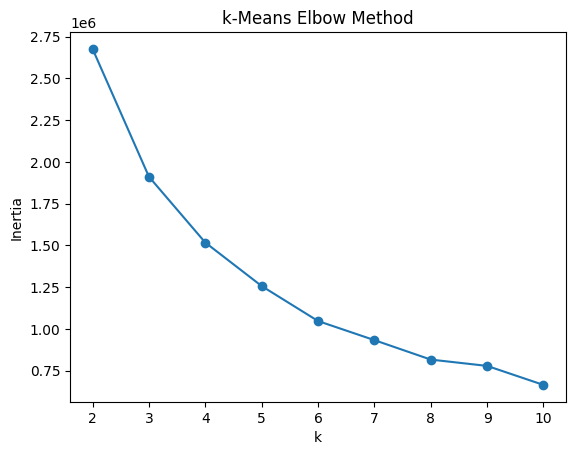

In [ ]:
from sklearn.cluster import KMeans

inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_train_proc)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(K, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("k-Means Elbow Method")
plt.show()


K-Means without PCA

In [ ]:
#reduce and use subsample due to high computation needs (collab)

# use if collab breaks import numpy as np

np.random.seed(42)

sample_n = 30000   # or even 20000
idx = np.random.choice(X_train_proc.shape[0], sample_n, replace=False)

X_km = X_train_proc[idx]
y_km = y_train.iloc[idx]


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_km)

ari_km, sil_km = cluster_scores(X_km, labels_km, y_km)
print("k-Means (no PCA) ARI:", ari_km, "Silhouette:", sil_km)


k-Means (no PCA) ARI: -0.00068196216662195 Silhouette: 0.330641570367984


K-Means with PCA

In [ ]:
# import numpy as np
np.random.seed(42)

sample_n = 30000  # try 20000 if still slow
idx = np.random.choice(X_train_proc.shape[0], sample_n, replace=False)

X_sub = X_train_proc[idx]
y_sub = y_train.iloc[idx]


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# choose components safely
svd_k = min(20, X_sub.shape[1] - 1)  # must be <= n_features-1
print("n_features:", X_sub.shape[1], " -> using svd_k:", svd_k)

X_svd = TruncatedSVD(n_components=svd_k, random_state=42).fit_transform(X_sub)

kmeans_pca = KMeans(n_clusters=6, random_state=42, n_init="auto")
labels_km_pca = kmeans_pca.fit_predict(X_svd)

ari_km_pca, sil_km_pca = cluster_scores(X_svd, labels_km_pca, y_sub)
print(f"k-Means (SVD={svd_k}) ARI:", ari_km_pca, "Silhouette:", sil_km_pca)



n_features: 6  -> using svd_k: 5
k-Means (SVD=5) ARI: -0.00068196216662195 Silhouette: 0.3306415703878333


In [ ]:
print("X_train_proc shape:", X_train_proc.shape)
print("X_sub shape:", X_sub.shape)


X_train_proc shape: (1182685, 6)
X_sub shape: (30000, 6)


Agglomerative/Hierarchical Clustering

In [ ]:
# No PCA

from sklearn.cluster import AgglomerativeClustering
import numpy as np

np.random.seed(42)

sample_n = min(30000, X_train_proc.shape[0])
idx = np.random.choice(X_train_proc.shape[0], sample_n, replace=False)

X_s = X_train_proc[idx]
y_s = y_train.iloc[idx].to_numpy()

agg = AgglomerativeClustering(n_clusters=6)
labels_agg = agg.fit_predict(X_s)

ari_agg, sil_agg = cluster_scores(X_s, labels_agg, y_s)
print("Agglomerative (no PCA) ARI:", ari_agg, "Silhouette:", sil_agg)



Agglomerative (no PCA) ARI: 0.0060236576759913965 Silhouette: 0.25421860534309415


In [ ]:
# PCA

from sklearn.decomposition import TruncatedSVD

svd_k = min(5, X_s.shape[1] - 1)
X_s_pca = TruncatedSVD(n_components=svd_k, random_state=42).fit_transform(X_s)

agg_pca = AgglomerativeClustering(n_clusters=6)
labels_agg_pca = agg_pca.fit_predict(X_s_pca)

ari_agg_pca, sil_agg_pca = cluster_scores(X_s_pca, labels_agg_pca, y_s)
print("Agglomerative (PCA) ARI:", ari_agg_pca, "Silhouette:", sil_agg_pca)


Agglomerative (PCA) ARI: -0.003962716624913207 Silhouette: 0.26521978767914556


In [ ]:
# DBScan

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, min_samples=20)
labels_db = db.fit_predict(X_sub)

ari_db, sil_db = cluster_scores(X_sub, labels_db, y_sub)
print("DBSCAN (no PCA) ARI:", ari_db, "Silhouette:", sil_db)



DBSCAN (no PCA) ARI: 0.006869786246461949 Silhouette: 0.26586973828581456


In [ ]:
db_pca = DBSCAN(eps=1.2, min_samples=20)
labels_db_pca = db_pca.fit_predict(X_svd)

ari_db_pca, sil_db_pca = cluster_scores(X_svd, labels_db_pca, y_sub)
print(f"DBSCAN (SVD={svd_k}) ARI:", ari_db_pca, "Silhouette:", sil_db_pca)


DBSCAN (SVD=5) ARI: 0.007304824701226716 Silhouette: 0.2553165258132319


In [ ]:
results = pd.DataFrame({
    "Method": ["kMeans","kMeans","Agglomerative","Agglomerative","DBSCAN","DBSCAN"],
    "PCA": ["No", f"Yes (SVD={svd_k})", "No", f"Yes (SVD={svd_k})", "No", f"Yes (SVD={svd_k})"],
    "ARI": [ari_km, ari_km_pca, ari_agg, ari_agg_pca, ari_db, ari_db_pca],
    "Silhouette": [sil_km, sil_km_pca, sil_agg, sil_agg_pca, sil_db, sil_db_pca]
})

results


,Method,PCA,ARI,Silhouette
0,kMeans,No,-0.000682,0.330642
1,kMeans,Yes (SVD=5),-0.000682,0.330642
2,Agglomerative,No,0.006024,0.254219
3,Agglomerative,Yes (SVD=5),-0.003963,0.265220
4,DBSCAN,No,0.006870,0.265870
5,DBSCAN,Yes (SVD=5),0.007305,0.255317
